### Preliminares: Cargado de Librerías

_Preliminar 1_: Para estre proyecto requeriremos el uso de librerías como Pandas, Numpy, datetime y matplotlib para el trabajo de manejo, análisis y visualización de la información.

_Preliminar 2_: Algunas formas de visualización interesante sobre lo que se dice en un grupo o chat individual lo pueden mostrar gráficos como un mapa de nubes (_wordcloud_)y para añadirle un toque de color, una librería que permite mostrar los emojis (esta se puede instalar usando el comando ***pip (pip3) install emoji***.

In [2]:
pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 6.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import plotly.express as px

import re
import regex
import emoji
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

*Preliminar 3 (opcional)*: Si se trabaja en un entorno de Google Colaboratory, se debe ejecutar esta celda para obtener la ruta del archivo de mensaje.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Funciones Principales

#### Función de Inicio y Fin

In [5]:
def IniciaConFechaYHora(s):
    # Ejemplo: '19/11/2023 21:12'
    patron = '^(\d{1,2})\/(\d{1,2})\/(\d{2,4}) (\d{1,2}):(\d{2}) - ([^:]+):'
    resultado = re.match(patron, s)  # Asegura que cada línea dentro del texto coincida con el formato, lo que establece el inicio y fin de cada una
    if resultado:
        return True
    return False

#### Detección de Miembros del grupo

In [11]:
# Patron para encontrar a los miembros del grupo dentro del txt
def EncontrarMiembro(s):
    patron = re.compile(r'^([^:]+):')

    # Buscar el patrón en cada mensaje de la conversación
    resultado = patron.findall(s)
    if resultado:
        return True
    return False

def EncontrarMiembro(s):
  patrones = [
        '([\w]+):',                                    # Nombre
        '([\w]+[\s]+[\(]+[\w]+[\)]+):',      # Nombre (Apodo)
        '([\w]+[\s]+[\w]+):',                    # Nombre + Apellido
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # Nombre 1 + Nombre 2 + Apellido
        '([+]\d{2} \d{3} \d{3} \d{3}):',     # Número de teléfono (Peru)
        '([\w]+)[\u263a-\U0001f999]+:', # Nombre + Emoji
        r'^([^:]+):', #Formato genérico
    ]
  patron = '^' + '|'.join(patrones)
  resultado = re.match(patron, s)  # Verificar si cada línea del txt hace match con el patrón de miembro
  if resultado:
    return True
  return False

#### Función para separar cada línea del mensaje en: fecha, hora, miembro y mensaje

In [12]:
def ObtenerPartes(linea):
    if IniciaConFechaYHora(linea):
        splitLinea = linea.split(' - ')
        FechaHora = splitLinea[0]
        splitFechaHora = FechaHora.split(' ')
        Fecha = splitFechaHora[0]
        Hora = ' '.join(splitFechaHora[1:])
        Mensaje = ' '.join(splitLinea[1:])

        # Verifica si el mensaje contiene emojis y ajústalo según sea necesario
        if EncontrarMiembro(Mensaje):
            splitMensaje = Mensaje.split(': ')
            Miembro = splitMensaje[0]

            # Manejar el caso especial de emojis dentro del nombre del miembro
            if any(emoji.is_emoji(c) for c in Miembro):
                # Extraer el contenido del mensaje después del nombre del miembro
                contenido_mensaje = Mensaje.split(': ', 1)[1] if len(splitMensaje) > 1 else ''
                Mensaje = contenido_mensaje
            else:
                Mensaje = ' '.join(splitMensaje[1:]) if len(splitMensaje) > 1 else ''
        else:
            Miembro = None
            Mensaje = ''
        return Fecha, Hora, Miembro, Mensaje

### Tratamiento de los Mensajes

In [18]:
# Leer el archivo txt descargado del chat de WhatsApp
RutaChat = '/content/drive/MyDrive/DataFC/Chat Data Analytics IISE PUCP.txt'

# Lista para almacenar los datos (Fecha, Hora, Miembro, Mensaje) de cada línea del txt
DatosLista = []
with open(RutaChat, encoding="utf-8") as fp:
    fp.readline() # Eliminar primera fila relacionada al cifrado de extremo a extremo
    VerificarMensaje = [] # Lista para verificar que no existan mensajes vacíos
    Fecha, Hora, Miembro = None, None, None
    while True:
        linea = fp.readline()
        if not linea:
            break
        linea = linea.strip()
        if IniciaConFechaYHora(linea): # Si cada línea del txt coincide con el patrón fecha y hora
            if len(VerificarMensaje) > 0:
                # Añadir un elemento lista que contendrá los datos a la lista 'DatosLista'
                DatosLista.append([Fecha, Hora, Miembro, ' '.join(VerificarMensaje)])
            VerificarMensaje.clear()
            Fecha, Hora, Miembro, Mensaje = ObtenerPartes(linea) # Obtener datos de cada línea del txt
            VerificarMensaje.append(Mensaje)
        else:
            VerificarMensaje.append(linea)

# Convertir la lista con los datos a dataframe
df = pd.DataFrame(DatosLista, columns=['Fecha', 'Hora', 'Miembro', 'Mensaje'])

# Eliminar los posibles campos vacíos del dataframe
# y lo que no son mensajes como cambiar el asunto del grupo o agregar a alguien
df = df.dropna()

# Cambiar la columna Fecha a formato datetime
df['Fecha'] = [i.replace('/23','/2023') for i in df['Fecha']]
df['Fecha'] = pd.to_datetime(df['Fecha'], format="%d/%m/%Y")

# Resetear el índice
df.reset_index(drop=True, inplace=True)
print(df)

          Fecha   Hora              Miembro  \
0    2023-04-10  10:20       Ryan Herrera 💻   
1    2023-04-10  10:20       Ryan Herrera 💻   
2    2023-04-10  10:20       Ryan Herrera 💻   
3    2023-04-10  10:21  Andrea Villafana 🖥️   
4    2023-04-10  10:21       Ryan Herrera 💻   
...         ...    ...                  ...   
7290 2023-11-18  09:03     Josselin Diestra   
7291 2023-11-18  14:35    Mauricio Murrieta   
7292 2023-11-18  14:35    Mauricio Murrieta   
7293 2023-11-18  14:35    Mauricio Murrieta   
7294 2023-11-18  14:35    Mauricio Murrieta   

                                  Mensaje  
0               Y.... nuestros repres? XD  
1                       Vamos sumándolos?  
2                            @51922772305  
3                               _grillos_  
4                                      XD  
...                                   ...  
7290                 <Multimedia omitido>  
7291  https://forms.gle/LuTNWmTFtzPHMWuC6  
7292                                Gen

### Algunas Estadísticas sobre los Mensajes

#### Mensajes, Multimedia, Emojis y Links

##### Extracción de datos sobre los caracteres de cada mensaje

In [19]:
def ObtenerEmojis(Mensaje):
    emoji_lista = []
    data = regex.findall(r'\X', Mensaje)  # Obtener lista de caracteres de cada mensaje
    for caracter in data:
        if emoji.is_emoji(caracter):
            emoji_lista.append(caracter)
    return emoji_lista

##### Recuento de principales mensajes

In [20]:
# Obtener la cantidad total de mensajes
total_mensajes = df.shape[0]

# Obtener la cantidad de archivos multimedia enviados
multimedia_mensajes = df[df['Mensaje'] == '<Multimedia omitido>'].shape[0]

# Obtener la cantidad de emojis enviados
df['Emojis'] = [ObtenerEmojis(i) for i in df['Mensaje']]
emojis = sum(df['Emojis'].str.len())

# Obtener la cantidad de links enviados
url_patron = r'(https?://\S+)'
df['URLs'] = df['Mensaje'].apply(lambda x: re.findall(url_patron, x)).str.len() # Se agrega columna 'URLs'
links = np.sum(df.URLs)

# Todos los datos pasarlo a diccionario
estadistica_dict = {'Tipo': ['Mensajes', 'Multimedia', 'Emojis', 'Links'],
        'Cantidad': [total_mensajes, multimedia_mensajes, emojis, links]
        }

#Convertir diccionario a dataframe
estadistica_df = pd.DataFrame(estadistica_dict, columns = ['Tipo', 'Cantidad'])

# Establecer la columna Tipo como índice
estadistica_df = estadistica_df.set_index('Tipo')
estadistica_df

,Cantidad
Tipo,
Mensajes,7295
Multimedia,1424
Emojis,1821
Links,111


##### Emojis más usados

In [21]:
# Obtener emojis más usados y las cantidades en el chat del grupo del dataframe
emojis_lista = list([a for b in df.Emojis for a in b])
emoji_diccionario = dict(Counter(emojis_lista))
emoji_diccionario = sorted(emoji_diccionario.items(), key=lambda x: x[1], reverse=True)

# Convertir el diccionario a dataframe
emoji_df = pd.DataFrame(emoji_diccionario, columns=['Emoji', 'Cantidad'])

# Establecer la columna Emoji como índice
emoji_df = emoji_df.set_index('Emoji')

print('Número emojis únicos usados: ', len(emoji_df), '\n')
emoji_df = emoji_df.head(10)
print(emoji_df)

Número emojis únicos usados:  152 

       Cantidad
Emoji          
🥳           177
👀           159
😁           123
🙌           102
🥲            86
😔            77
😭            70
🥺            67
🎉            65
❤️           64


#### Pie Chart de Emojis

In [22]:
# Plotear el pie de los emojis más usados
fig = px.pie(emoji_df, values='Cantidad', names=emoji_df.index, title='Pie de emojis')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

### Actividad dentro del Chat

In [30]:
# Determinar los miembros más activos del grupo
df_MiembrosActivos = df.groupby('Miembro')['Mensaje'].count().sort_values(ascending=False).to_frame()
df_MiembrosActivos.reset_index(inplace=True)
df_MiembrosActivos.index = np.arange(1, len(df_MiembrosActivos)+1)
df_MiembrosActivos.head(10)

,Miembro,Mensaje
1,Ryan Herrera 💻,1989
2,Mayito Bondia 🐣,1622
3,Eduardo Cuya,1383
4,Sandro Agama 😎,489
5,Bruno Tarco,242
6,Sergio Valera,229
7,Andrea Villafana 🖥️,218
8,Josselin Diestra,190
9,Johann Gonzáles,187
10,Luis Jerí,122


#### Contenido por Mensaje

In [24]:
# Separar mensajes (sin multimedia) y multimedia (stickers, fotos, videos)
multimedia_df = df[df['Mensaje'] == '<Multimedia omitido>']
mensajes_df = df.drop(multimedia_df.index)

# Contar la cantidad de palabras y letras por mensaje
mensajes_df['Letras'] = mensajes_df['Mensaje'].apply(lambda s : len(s))
mensajes_df['Palabras'] = mensajes_df['Mensaje'].apply(lambda s : len(s.split(' ')))
mensajes_df.tail()

,Fecha,Hora,Miembro,Mensaje,Emojis,URLs,Letras,Palabras
7288,2023-11-18,07:06,Mayito Bondia 🐣,"@51997828774 si vas ,tambien voy 🫣, tu y mi me...","[🫣, 🫶, 🥰]",0,117,20
7291,2023-11-18,14:35,Mauricio Murrieta,https://forms.gle/LuTNWmTFtzPHMWuC6,[],1,35,1
7292,2023-11-18,14:35,Mauricio Murrieta,Gente,[],0,5,1
7293,2023-11-18,14:35,Mauricio Murrieta,Llenen pls,[],0,10,2
7294,2023-11-18,14:35,Mauricio Murrieta,Estoy sorteando 100 y 200 soles,[],0,31,6


Algunas Estadísticas por Mensaje

In [26]:
# Obtener a todos los miembros
miembros = mensajes_df.Miembro.unique()

# Crear diccionario donde se almacenará todos los datos
dictionario = {}

for i in range(len(miembros)):
  lista = []
  # Filtrar mensajes de un miembro en específico
  miembro_df= mensajes_df[mensajes_df['Miembro'] == miembros[i]]

  # Agregar a la lista el número total de mensajes enviados
  lista.append(miembro_df.shape[0])

  # Agregar a la lista el número de palabras por total de mensajes (palabras por mensaje)
  palabras_por_msj = (np.sum(miembro_df['Palabras']))/miembro_df.shape[0]
  lista.append(palabras_por_msj )

  # Agregar a la lista el número de mensajes multimedia enviados
  multimedia = multimedia_df[multimedia_df['Miembro'] == miembros[i]].shape[0]
  lista.append(multimedia)

  # Agregar a la lista el número total de emojis enviados
  emojis = sum(miembro_df['Emojis'].str.len())
  lista.append(emojis)

  # Agregar a la lista el número total de links enviados
  links = sum(miembro_df['URLs'])
  lista.append(links)

  # Asignar la lista como valor a la llave del diccionario
  dictionario[miembros[i]] = lista

#Algunos ajustes de formato y etiquetas de datos
df_dictionario = pd.DataFrame(dictionario)
df_dictionario['Metrica'] = ['Mensajes de Texto','Palabras Promedio por Mnesaje','Contenido Multimedia Enviado','Emojis Enviados','Links Enviados']

print(df_dictionario)

   Ryan Herrera 💻  Andrea Villafana 🖥️  Josselin Diestra      Marco  \
0     1644.000000               180.00        185.000000  12.000000   
1        6.547445                15.75         14.724324  17.083333   
2      345.000000                38.00          5.000000   0.000000   
3      173.000000                75.00        509.000000   6.000000   
4       33.000000                17.00          4.000000   2.000000   

   Sandro Agama 😎  Marcela Sotomayor   Luis Jerí  Marcelo Rojas  \
0      366.000000          44.000000  116.000000            2.0   
1        6.871585           5.409091    6.551724           19.5   
2      123.000000           1.000000    6.000000            0.0   
3       88.000000          25.000000    4.000000            1.0   
4       12.000000           0.000000    0.000000            0.0   

   Mayito Bondia 🐣  Jessica Karina  ...  Lucía Corrales  Bruno Tarco  \
0      1502.000000       13.000000  ...            15.0   165.000000   
1         5.382157       1

### Fechas más Activas

Text(0, 0.5, 'Fecha')

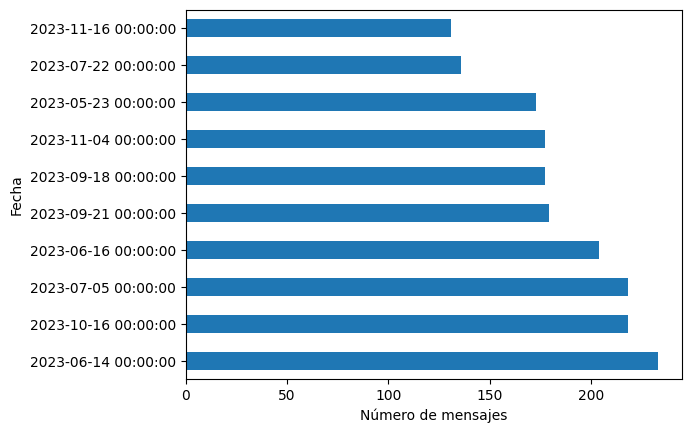

In [27]:
# Determinar los días más activos del grupo
df['Fecha'].value_counts().head(10).plot.barh() # Plotear 10 días
plt.xlabel('Número de mensajes')
plt.ylabel('Fecha')

### Horas más activas

Text(0, 0.5, 'Fecha')

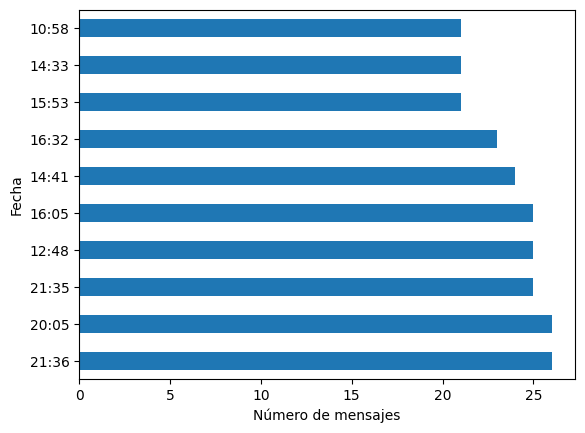

In [28]:
# Determinar las horas en las que el grupo está más activo
df['Hora'].value_counts().head(10).plot.barh()
plt.xlabel('Número de mensajes')
plt.ylabel('Fecha')

### WordCloud de Palabras

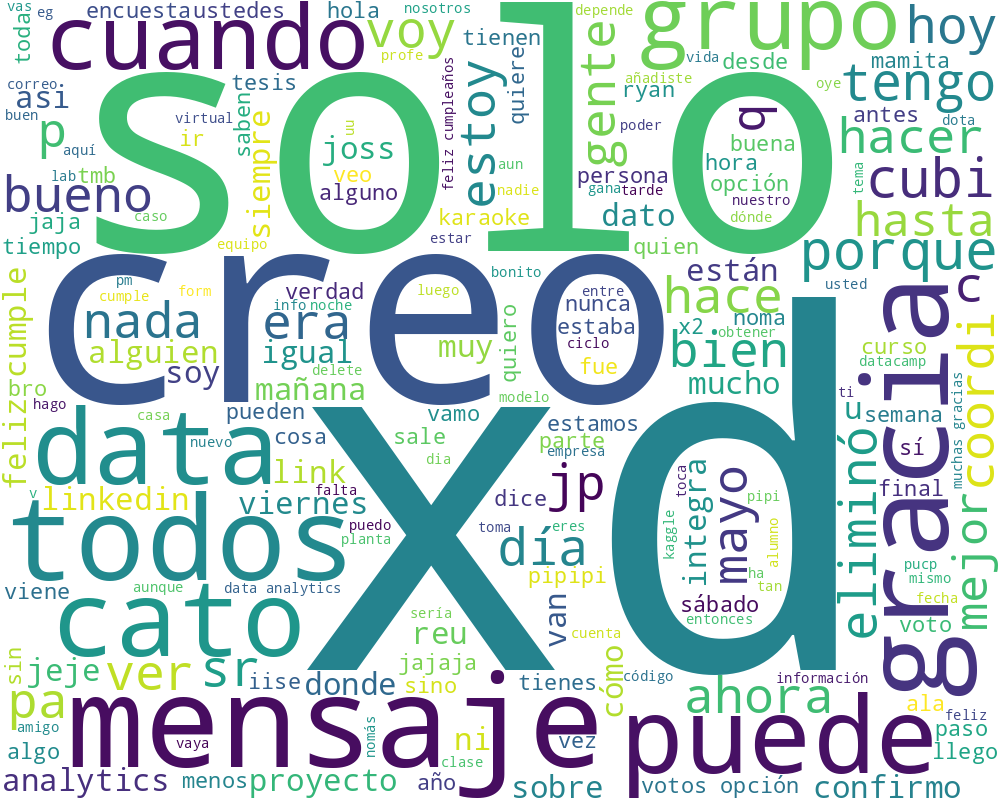

In [29]:
# Crear un string que contendrá todas las palabras
total_palabras = ' '
stopwords = STOPWORDS.update(['que', 'qué', 'con', 'de', 'te', 'en', 'la', 'lo', 'le', 'el', 'las', 'los', 'les', 'por', 'es',
                                                         'son', 'se', 'para', 'un', 'una', 'chicos', 'su', 'si', 'chic', 'nos', 'ya', 'hay', 'esta',
                                                         'pero', 'del', 'mas', 'más', 'eso', 'este', 'como', 'así', 'todo', 'https', 'tu', 'y', 'al',
                                                         'mi', 'tus', 'esa', 'o', 'sus', 'tiene', 'también', 'tambien', 'sea', 'esos', 'esto', 'ese',
                                                         'uno', 'ahi', 'ahí', 'va', 'está', 'yo', 'tenga', 'ser', 'otra', 'otro', 'mis', 'han'])

# Obtener y acumular todas las palabras de cada mensaje
for mensaje in mensajes_df['Mensaje'].values:
  palabras = str(mensaje).lower().split() # Obtener las palabras de cada línea del txt
  for palabra in palabras:
    total_palabras = total_palabras + palabra + ' ' # Acumular todas las palabras

wordcloud = WordCloud(width = 1000, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(total_palabras)

# Plotear la nube de palabras más usadas
wordcloud.to_image()